In [1]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
train_data_dir = "soil_img/train"
validation_data_dir = "soil_img/validation"
test_data_dir = "soil_img/test"

train_datagen = image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150,150),
    class_mode="categorical"
)

validation_datagen = image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(150,150),
    class_mode="categorical"
)

test_datagen = image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(150,150),
    class_mode="categorical"
)

Found 300 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


Found 50 images belonging to 5 classes.


In [3]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [4]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [5]:
history = model.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20
10/10 [==============================] - 11s 982ms/step - loss: 1.6234 - accuracy: 0.3633 - val_loss: 1.1760 - val_accuracy: 0.4800
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 1.0101 - accuracy: 0.5233 - val_loss: 1.1550 - val_accuracy: 0.4600
Epoch 3/20
10/10 [==============================] - 10s 998ms/step - loss: 0.9143 - accuracy: 0.5967 - val_loss: 0.7190 - val_accuracy: 0.7400
Epoch 4/20
10/10 [==============================] - 10s 996ms/step - loss: 0.7117 - accuracy: 0.7267 - val_loss: 0.6362 - val_accuracy: 0.7200
Epoch 5/20
10/10 [==============================] - 8s 733ms/step - loss: 0.6184 - accuracy: 0.7600 - val_loss: 0.8277 - val_accuracy: 0.6600
Epoch 6/20
10/10 [==============================] - 7s 659ms/step - loss: 0.5726 - accuracy: 0.7833 - val_loss: 0.5124 - val_accuracy: 0.8400
Epoch 7/20
10/10 [==============================] - 8s 827ms/step - loss: 0.4289 - accuracy: 0.8467 - val_loss: 0.5287 - val_accuracy: 0.8000
Epoch

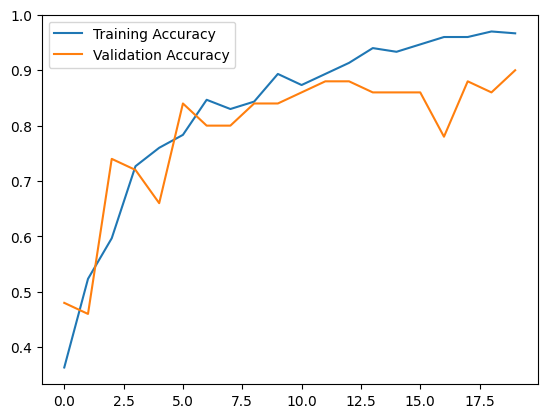

In [6]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.show()

In [7]:
pred = model.evaluate(test_generator)

2/2 [==============================] - 0s 65ms/step - loss: 1.5299 - accuracy: 0.7200


In [8]:
model.save_weights("model_weights.h5")

In [9]:
import tensorflow as tf

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpj7vj6tx2\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpj7vj6tx2\assets


In [11]:
with open('soil_clf_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [12]:
# testing
test_img = image.load_img('Black.jpg', target_size=(150,150))
test_img_array = image.img_to_array(test_img)
test_img_array = np.expand_dims(test_img_array, axis=0)
test_img_array /= 255.0

In [13]:
prediction = model.predict(test_img_array)
print(f'Prediction: {prediction}')

predicted_class_index = np.argmax(prediction)
class_labels = ['alluvial', 'black', 'clay', 'red', 'reddish_brown_earth']
predicted_class_label = class_labels[predicted_class_index]
confidence_score = prediction[0, predicted_class_index]

print(f'Predicted Class: {predicted_class_label}')
print(f'Confidence Score: {confidence_score * 100: .2f}%')

1/1 [==============================] - 0s 89ms/step
Prediction: [[4.2511521e-05 9.9995744e-01 9.3715813e-11 6.0801708e-10 1.9371850e-10]]
Predicted Class: black
Confidence Score:  100.00%


In [ ]:
from pyngrok import ngrok
from flask import Flask, request, jsonify
from tensorflow.keras.preprocessing import image
import numpy as np
import base64
from PIL import Image
from io import BytesIO
import pickle
import requests
from tensorflow.keras.models import load_model

port_no = 5000

app = Flask(__name__)

ngrok.set_auth_token("2eJF9pgAY9p1YXdK60BumXhpbkM_7V88y5BngqyVx3KFv18dN")
public_url = ngrok.connect(port_no).public_url
# URL of the Flask server
flask_url = 'https://foodappbackend.jaffnamarriage.com/public/api/receive-url'
# Send POST request to the Flask server
response = requests.post(flask_url, data={'url': public_url})
# Define the file path to save/load the model
MODEL_FILE_PATH = 'model_weights.h5'

# Define a route to receive image and make predictions
@app.route('/getresponse', methods=['POST'])
def predict():
    # Check if the request contains JSON data
    if not request.is_json:
        return jsonify({'error': 'Request must be JSON'}), 400

    # Extract the JSON data from the request
    data = request.json

    # Check if the 'image' key is present in the JSON data
    if 'image' not in data:
        return jsonify({'error': 'No image data found'}), 400

    # Decode the Base64 encoded image data
    encoded_image = data['image']
    try:
        decoded_image = base64.b64decode(encoded_image)
    except Exception as e:
        return jsonify({'error': 'Invalid Base64 encoding'}), 400

    # Convert the decoded image data to PIL Image object
    try:
        img = Image.open(BytesIO(decoded_image))
    except Exception as e:
        return jsonify({'error': 'Unable to process image data'}), 400

    # Preprocess the image
    # img = img.resize((150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    model = load_model(MODEL_FILE_PATH)


    # Make predictions
    prediction = model.predict(img_array)

    # Process the prediction results
    predicted_class_index = np.argmax(prediction)
    class_labels = ['Alluvial soil', 'black soil', 'clay soil', 'red soil', 'Reddish Brown Earths soil']
    predicted_class_label = class_labels[predicted_class_index]
    confidence_score = float(prediction[0, predicted_class_index])

    return jsonify({
        'predicted_class': predicted_class_label,
        'confidence_score': confidence_score
    })
print(f"url: {public_url}")
if __name__ == '__main__':
    app.run( port=port_no)